# 0: Section Overview

In this section, we will impliment a baseline model. This will provide a basic model against which more complex models can be compared. This comparison will help us to gauge the effectiveness of enhancements or modifications made to the model. Additionally, It sets a standard for evaluating whether more sophisticated models actually provide improvements in predictive performance (in our case, this performance metric is measured as the MSE).

# 1: Necessary Imports

In [105]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import random
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import Lasso
import seaborn as sns

# 2: Data Access

We will access the data in the same way throughout the project.

In [58]:
test_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\test.xlsx" # Enter your file path for the train data
train_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\train.xlsx" # Enter your file path for the test data

test_data = pd.read_excel(test_filepath)
train_data = pd.read_excel(train_filepath)

# 3: Implimenting the baseline model: Linear Regression

Initally, let us train the model on the entire training data. Note that we don't require the first 4 columns (date, iso_code, continent and location). Therefore, the first thing we will do is remove these columns.

In [59]:
train_data_string_cols_rem = train_data.iloc[:, 4:]
test_data_string_cols_rem = test_data.iloc[:, 4:]

print(train_data_string_cols_rem.columns)

print(test_data.shape)
print(train_data.shape)
# iso_codes = test_data['iso_code'].unique()
# random_iso_code = random.choice(iso_codes)
# country_to_display = test_data[test_data['iso_code'] == random_iso_code]
# print(country_to_display)


Index(['Mean_Stringency_Index', 'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index',
       'days_since', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths',
       'reproduction_rate'],
      dtype='object')
(32431, 14)
(134618, 14)


### Training Data

We will select the relevant columns for our particular model, these being the dependent variable, 'reproduction_rate', and all the covariates, these being 'mean_stringency','CH Index', 'Gov Resp Index', 'Econ Sup Index' and 'days_since'. We also choose to remove any rows with missing values. Later on in the project we will evaluate how we can go about using those rows with missing information.

In [60]:
train_data_string_cols_rem = train_data.iloc[:, 4:]
test_data_string_cols_rem = test_data.iloc[:, 4:]
covariates = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths']
covariates_and_repr = covariates + ['reproduction_rate']
train_data_filtered = train_data_string_cols_rem[covariates_and_repr]
X_train = train_data_filtered[covariates]
y_train = train_data_filtered['reproduction_rate']
print()
print(X_train.shape)
print(len(y_train))



(134618, 9)
134618


### Testing Data

We impliment the same filtering as we did with the training data.

In [61]:
test_data_filtered = test_data_string_cols_rem[covariates_and_repr]
X_test = test_data_filtered[covariates]
y_test = test_data_filtered[['reproduction_rate']]
print()
print(X_test.shape)
print(len(y_test))


(32431, 9)
32431


### Running the model

In [119]:
linear_model = LinearRegression()
# Fit the model on the training data
linear_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = linear_model.predict(X_test)
# print("y_pred shape:", y_pred.shape)
# Calculate Mean Squared Error (MSE) on the test data
mse = mean_squared_error(y_test, y_pred)
R_squared = linear_model.score(X_test, y_test)
# Print the MSE result
print(f'Mean Squared Error on the test data: {mse:.4f}')
print(f'R^2: {R_squared:.4f}')


Mean Squared Error on the test data: 0.1326
R^2: 0.1851


An MSE of 0.1326 means that, on average, the squared difference between our predicted values and actual values is 0.1326. However, the absolute value of MSE alone doesn't provide much context unless understood in the context of the data's scale: 

In [124]:
print(np.mean(y_test))
print(np.std(y_test))
print(np.sqrt(mse))

0.9119114427553884
0.40339443486107884
0.36415449493647384


#### Assessing these results

Given that our target variable has a mean around 0.9119, an MSE of 0.1326 represents a significant error relative to the scale of our data. the Root Mean Squared Error (RMSE) is the square root of the MSE which in this case is roughly 0.364. The RMSE value of 0.364 indicates that, on average, the predictions are off by approximately 0.364 units from the actual values. Given we know the mean is roughly 0.9, this seems like a fairly large error and low performance model. Additionally, when considering the standard deviation we see that the root MSE is roughly 90% of the standard deviation so our errors are substantial relative to the intrinsic variation in the data. Therefore, as suspected, the linear baseline model does not perform well and is not caputuring relationsips in the data. Additionally the low R^2 value suggests that only 18% of the variance in the target variable can be explained by the independent variables in our linear model. This indicates that a significant portion of the variability remains unexplained. Other modeling techniques should be put into place to therefore yield better results.

### Feature importance with regularization

Given the low values of our R^2 values, Let us view the coefficient values of each of our covariates. We can analyse the magnitude of these coefficients to measure the strenght of the relationship between the particular covariate. However, keep in mind that these coefficientd are influenced by the scale of the features. If features are measured in different units or at different scales the coefficients may not be directly comparable without standardization (The scaling of the index values is not the same as the scaling of days_since or the scaling of the total_deaths).

As you can see in the below block, we also impliment the lasso model, a type of linear regression model, but includes an additional component for regularization. Essentially, the lasso model works shrink some coefficients exactly to zero if it deems them less relevant. As we see from the output, many of the coefficients have been signifcantly shrunk in the lasso model. Therefore whilst some coefficients are larger in the standard regression model such as Gov_resp_Index and CH_index suggesting they are deemed more relevant than other covariates in the model, the signifcantly shrunk coefficients in the lasso model indicate weak relationships between the features and the target variable (which is a notion mirrored by the value of R^2).

In [130]:
print('STANDARD LINEAR:')
coefficients = pd.DataFrame(linear_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients)

print() 
print('LASSO:')
lasso_model = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso_model.fit(X_train, y_train)

lasso_coefficients = pd.DataFrame(lasso_model.coef_, X_train.columns, columns=['Coefficient'])
lasso_coefficients['Absolute Coefficient'] = lasso_coefficients['Coefficient'].abs()
lasso_coefficients = lasso_coefficients.sort_values(by='Absolute Coefficient', ascending=False)

print(lasso_coefficients)

STANDARD LINEAR:
                        Coefficient  Absolute Coefficient
Gov_Resp_Index         2.216495e+00          2.216495e+00
CH_Index              -1.931886e+00          1.931886e+00
Econ_Sup_Index        -2.763285e-01          2.763285e-01
Mean_Stringency_Index -3.465247e-03          3.465247e-03
days_since            -3.414299e-04          3.414299e-04
new_deaths            -1.384598e-05          1.384598e-05
total_deaths           1.687026e-07          1.687026e-07
new_cases              1.441729e-08          1.441729e-08
total_cases            5.904141e-09          5.904141e-09

LASSO:
                        Coefficient  Absolute Coefficient
CH_Index               2.813578e-03          2.813578e-03
Econ_Sup_Index         8.222872e-04          8.222872e-04
Gov_Resp_Index         4.708249e-04          4.708249e-04
days_since            -2.739730e-04          2.739730e-04
new_deaths            -1.282647e-05          1.282647e-05
total_deaths           1.307603e-07          1.

#### Addressing a TypeError

In [63]:
print(type(y_test))  # Should be pandas.Series or numpy.ndarray
print(type(y_pred))  # Should be pandas.Series or numpy.ndarray

y_test = y_test.squeeze()  # Convert DataFrame to Series
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


# 4: Cross-validation

Since we have no hyperparameters to tune in the Baseline Linear model, Cross-validation will not be required. Hence we will not impliment it here.

# 5: Visualising model success

## 5.1: Scatter Plot

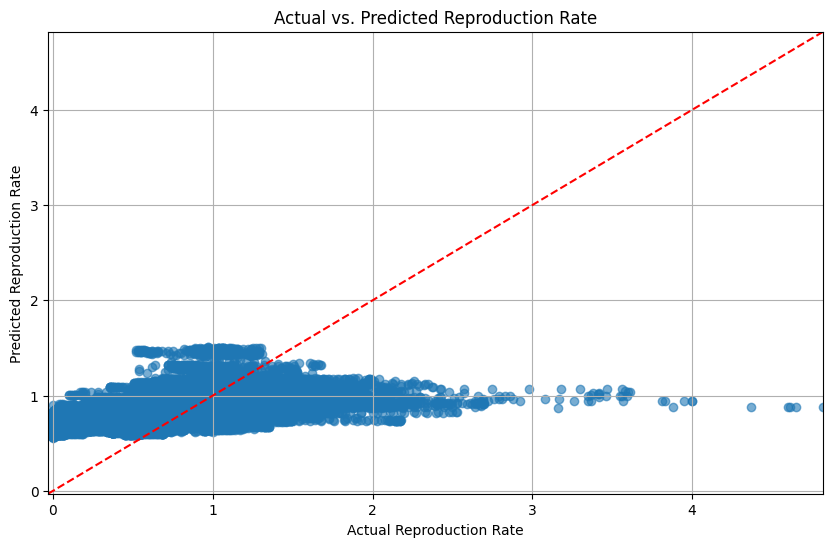

In [64]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.title('Actual vs. Predicted Reproduction Rate')
plt.xlabel('Actual Reproduction Rate')
plt.ylabel('Predicted Reproduction Rate')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])
plt.grid()
plt.show()

The above plot is a scatter plot that plots actual reproduction rate against the linear model's prediction for that particular row in the dataset. Essentially, better performing models will have more points closer to or on the red line (where actual reproduction rate = predicted reproduction rate) however whilst there are points near this line, it is clear the model is making errors as there are lots of points above and below the red line.


## 5.2: Residuals Plot

A residuals plot shows the residuals (the difference between actual and predicted values) on the y-axis against the predicted values on the x-axis. This can help identify any patterns in the errors.

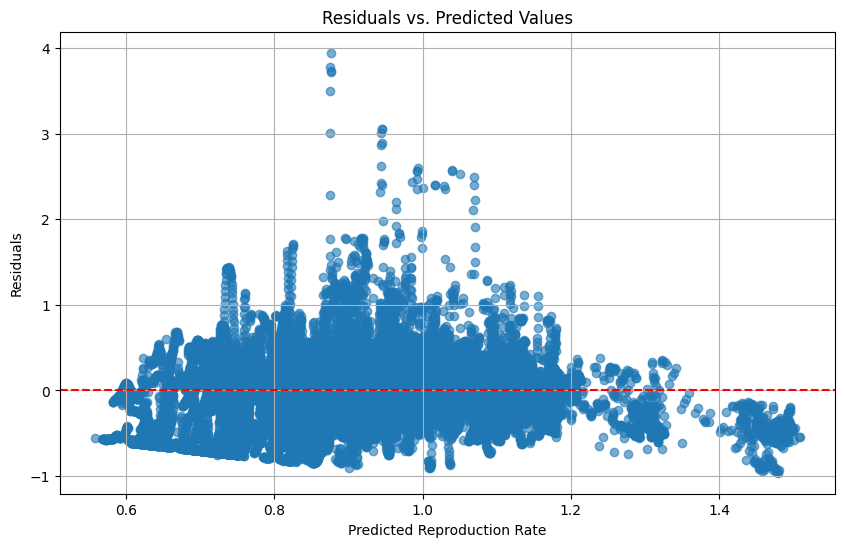

In [80]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')
plt.grid()
plt.show()


This plot shows similar information to the previous plot however now we are directly plotting the residual values of the baseline model. Since we have a large number of data points, it is difficult to see how densly populated the residuals are around the line y = 0. We can use the hexbin function in the matplot library to overlay a heatmap on the residuals plot which allows us to see where the data points are more densely populated.


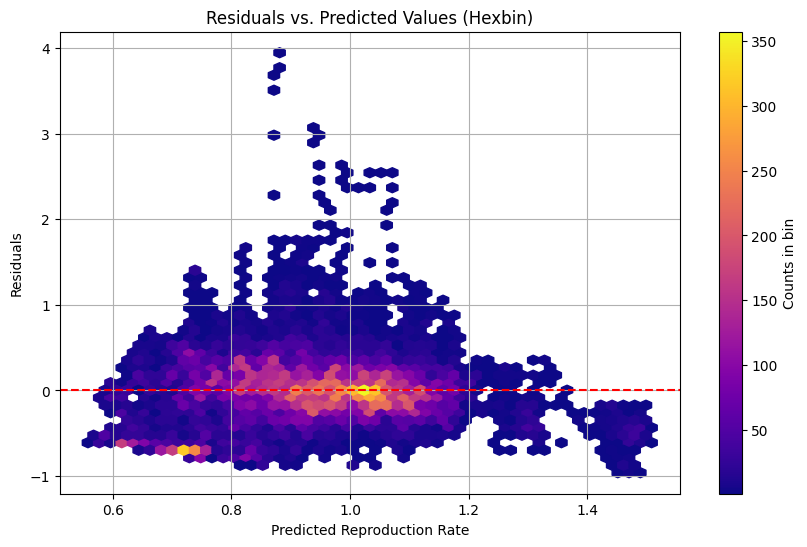

In [103]:
# Calculate residuals

# Create a hexbin plot with a different color scheme
plt.figure(figsize=(10, 6))
plt.hexbin(y_pred, residuals, gridsize=50, cmap='plasma', mincnt=1)  # Use 'plasma' color map
plt.colorbar(label='Counts in bin')  # Show color bar
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values (Hexbin)')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')
plt.grid()
plt.show()


Here, we can see that the most densly populated areas are where residuals are closer to 0 as that is where the lighter areas are shown on the graph. However, let us zoom in closer on the central residuals to get tighter limits on the residuals axis with a smaller intervals displayed on the y-axis.

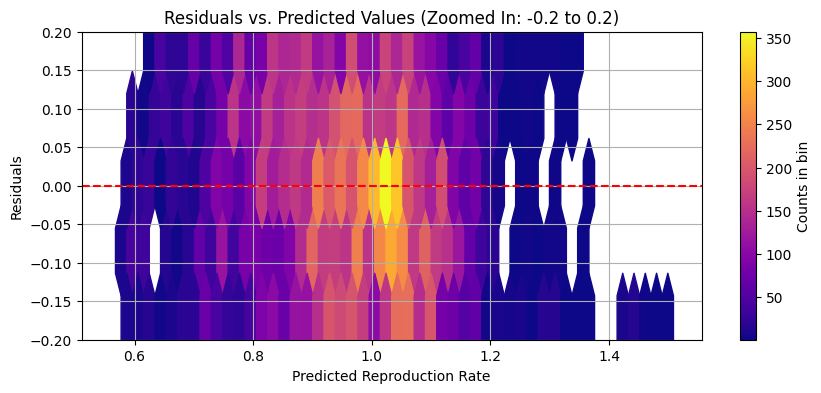

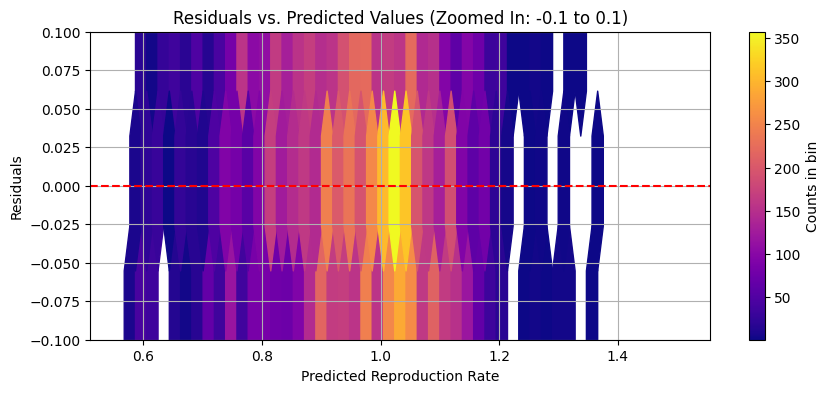

In [111]:
import matplotlib.pyplot as plt

# Create a hexbin plot for residuals vs. predicted values
def plot_hexbin(y_pred, residuals, ylim_lower, ylim_upper, title_suffix=''):
    plt.figure(figsize=(10, 4))  # Size adjustment
    plt.hexbin(y_pred, residuals, gridsize=50, cmap='plasma', mincnt=1)  # Use 'plasma' color map
    plt.colorbar(label='Counts in bin')  # Show color bar
    plt.axhline(0, color='red', linestyle='--')  # Line at 0
    plt.title(f'Residuals vs. Predicted Values {title_suffix}')
    plt.xlabel('Predicted Reproduction Rate')
    plt.ylabel('Residuals')

    # Set tighter limits for y-axis to focus on smaller residuals
    plt.ylim(ylim_lower, ylim_upper)  # Adjust the limits for more zoom
    plt.grid()
    plt.show()

# First plot with y-limits of -0.2 to 0.2
plot_hexbin(y_pred, residuals, ylim_lower=-0.2, ylim_upper=0.2, title_suffix='(Zoomed In: -0.2 to 0.2)')

# Second plot with y-limits of -0.1 to 0.1
plot_hexbin(y_pred, residuals, ylim_lower=-0.1, ylim_upper=0.1, title_suffix='(Zoomed In: -0.1 to 0.1)')




The plot shows that the majority of residuals are within the range of -0.05 to 0.05. This concentration of points near zero suggests that for these predictions, the model’s predicted values are within this range of the actual values. This suggests that, whilst the model is making errors, The model does not tend to frequently make large deviations from the actual values. However, it is important to note that if the values of 
predicted reproduction_rate and actual_reproduction_rate are relatively small, then the residuals, which are the absolute differences between them, may also be small simply due to the scale.

## 5.3: Histogram of Residuals

the histogram of the residuals can show the distribution of errors. We see that the histogram of residuls looks roughly normally distributed around 0 with a mean of -0.0218. It also seems that the errors have a symmetrical distribution, with equal occurrences of positive and negative errors implying that there is no systematic bias in the predictions (e.g. if the model was consistently overestimating or underestimating, this would be shown in the histogram with a skey in distribution).

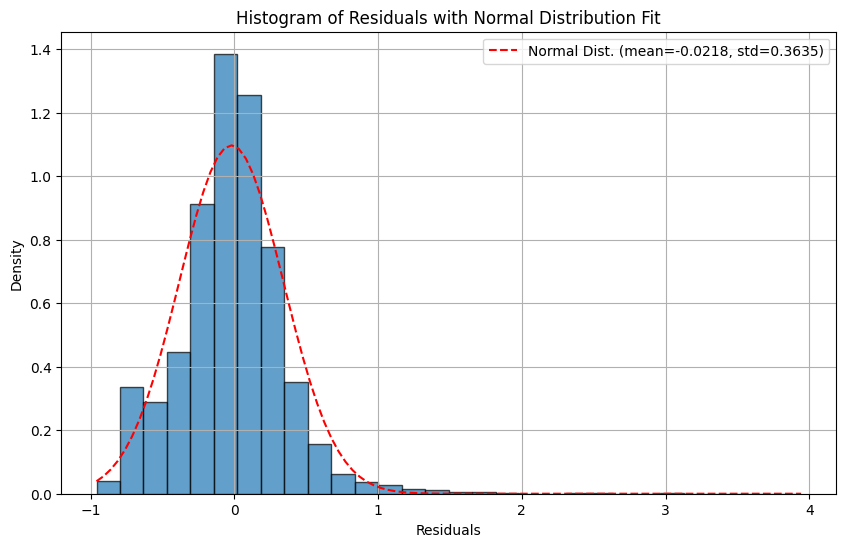

In [117]:

# Assuming you have already calculated residuals

# Calculate the mean and standard deviation of residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Generate values for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)  # 100 values between the min and max of residuals
normal_dist = stats.norm.pdf(x, mean_residuals, std_residuals)  # Probability density function of the normal distribution

# Create a histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, edgecolor='black', alpha=0.7)  # Use density=True to normalize the histogram
plt.title('Histogram of Residuals with Normal Distribution Fit')
plt.xlabel('Residuals')
plt.ylabel('Density')  # Changing to density instead of frequency

# Plot the normal distribution curve
plt.plot(x, normal_dist, 'r--', label=f'Normal Dist. (mean={mean_residuals:.4f}, std={std_residuals:.4f})')

# Add grid and legend
plt.grid(True)
plt.legend()
plt.show()


## References